<font size = "5"> **Chapter 4:  [Spectroscopy](Ch4-Spectroscopy.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of Core-Loss Spectra

part of 

<font size = "5"> **[Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)**</font>


by Gerd Duscher, 2020

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes


## Install the newest version of sidpy
This notebook will only run with  ``version 0.0.3`` or higher.

In [2]:
import sys
from IPython.lib.deepreload import reload as dreload

try:
    import sidpy 
except ModuleNotFoundError:
    !pip3 install sidpy
if sidpy.__version__ < '0.0.3':
    !{sys.executable} -m pip install  --upgrade sidpy
    dreload(sidpy)
try:
    import pyNSID 
except ModuleNotFoundError:
    !{sys.executable} -m pip install  --upgrade pyNSID
try:
    import pyTEMlib
except ModuleNotFoundError:
    !{sys.executable} -m pip install  --upgrade pyTEMlib
if pyTEMlib.__version__ < '0.2020.12.0':
    !{sys.executable} -m pip install  --upgrade pyTEMlib
    dreload(pyTEMlib)   

  Attempting uninstall: pyTEMlib
    Found existing installation: pyTEMlib 0.2020.11.1
    Uninstalling pyTEMlib-0.2020.11.1:
      Successfully uninstalled pyTEMlib-0.2020.11.1
ReloadingReloading _io
 zmq


Reloading _io
Reloading sys
Reloading platform
Reloading collections
Reloading _collections_abc
Reloading abc
Reloading _abc
Reloading operator
Reloading builtins


## Content

Quantitative determination of chemical composition from a core-loss EELS spectrum

Please cite:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of this quantification method.

## First we import the relevant packages

In [5]:
%pylab --no-import-all notebook
%gui qt 

%load_ext autoreload
%autoreload 2

import sys
#sys.path.insert(0,'../../')

import pyTEMlib
import pyTEMlib.file_tools as ft
import pyTEMlib.image_tools as it
import pyTEMlib.eels_tools  as eels        # EELS methods 
import pyTEMlib.interactive_eels as ieels  # Dialogs for EELS input and quantification

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = 'analyse_core_loss'
__notebook_version__ = '2020_11_03'

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pyTEM version:  0.2020.12.0


%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../pyTEMlib/')

## Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.

Please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details on storage and plotting.

First a dialog to select a file will apear.

Then the spectrum plot and ``Spectrum Info`` dialog will appear, in which we set the experimental parameters.

Please use the ``Set Energy Scale`` button to change the energy scale. When pressed a new dialog and a cursor will appear in which one is able to set the energy scale based on known features in the spectrum.


Cannot overwrite file. Using:  01-EELS Acquire_STO-31.hf5
<HDF5 group "/Measurement_000/Channel_000" (0 members)> 01_EELS Acquire_STO


<IPython.core.display.Javascript object>


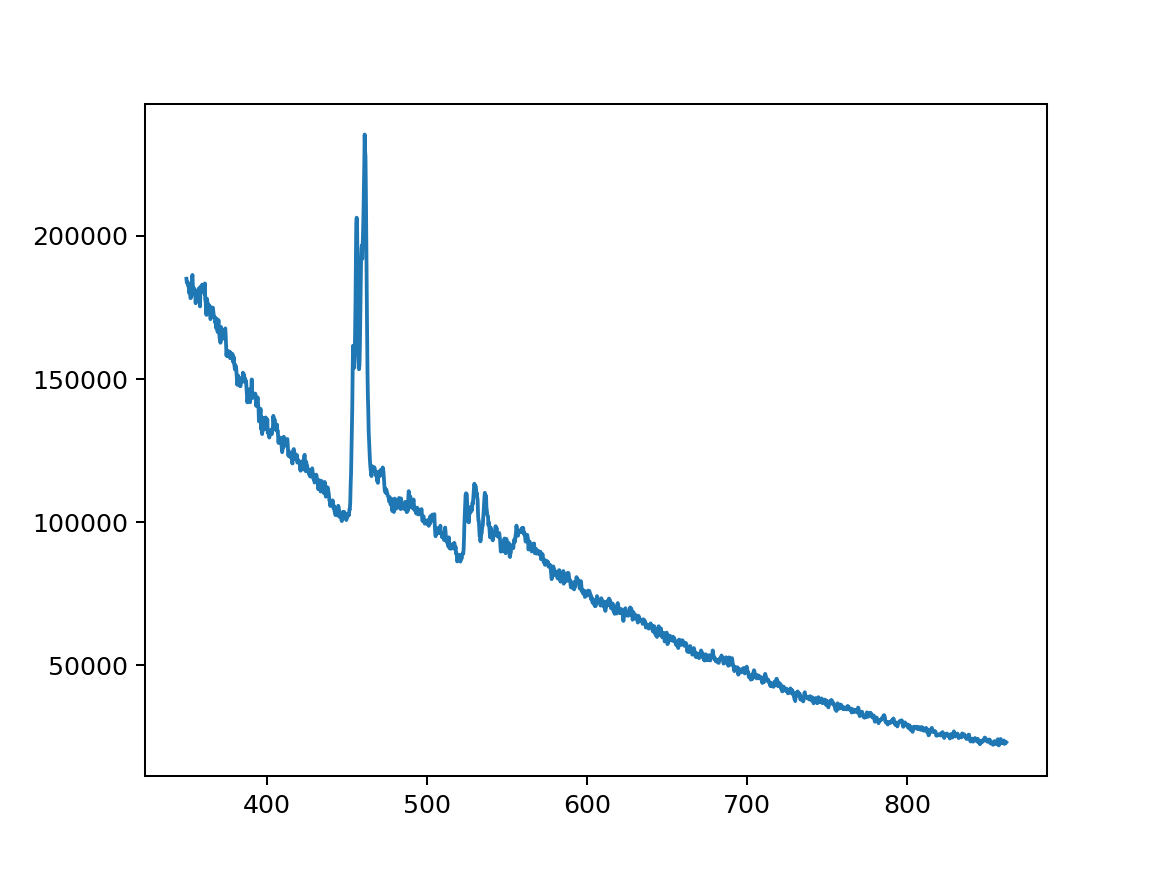

In [6]:
try:
    current_dataset.h5_dataset.file.close()
except:
    pass

current_dataset = ft.open_file()

current_channel = current_dataset.h5_dataset.parent

eels.set_previous_quantification(current_dataset)

# US 200 does not set acceleration voltage correctly.
# comment out next line  for other microscopes
current_dataset.metadata['experiment']['acceleration_voltage'] = 200000

info = ieels.InfoDialog(current_dataset)



In [8]:
current_dataset = ft.open_file('EELS_STO.dm3')

<HDF5 group "/Measurement_000/Channel_000" (0 members)> EELS_STO


## Chemical Composition 
The fit of the cross-section and background to the spectrum results in the chemical composition. If the calibration is correct this composition is given as areal density in atoms/nm$^2$


###  Fit of Data
A dialog window will open, enter the elements first (0 will open a periodic table) and press 
``Fit Composition`` button (bottom right). Adjust parameters as needed and check fit by pressing the ``Fit Composition`` button again.

Select the ``Region`` checkbox to see which parts of the spectrum you choose to fit.

Changing the multiplier value will make a simulation of your spectrum.

The ``InfoDialog``, if open, still works to change experimental parameters and the energy scale.

<IPython.core.display.Javascript object>


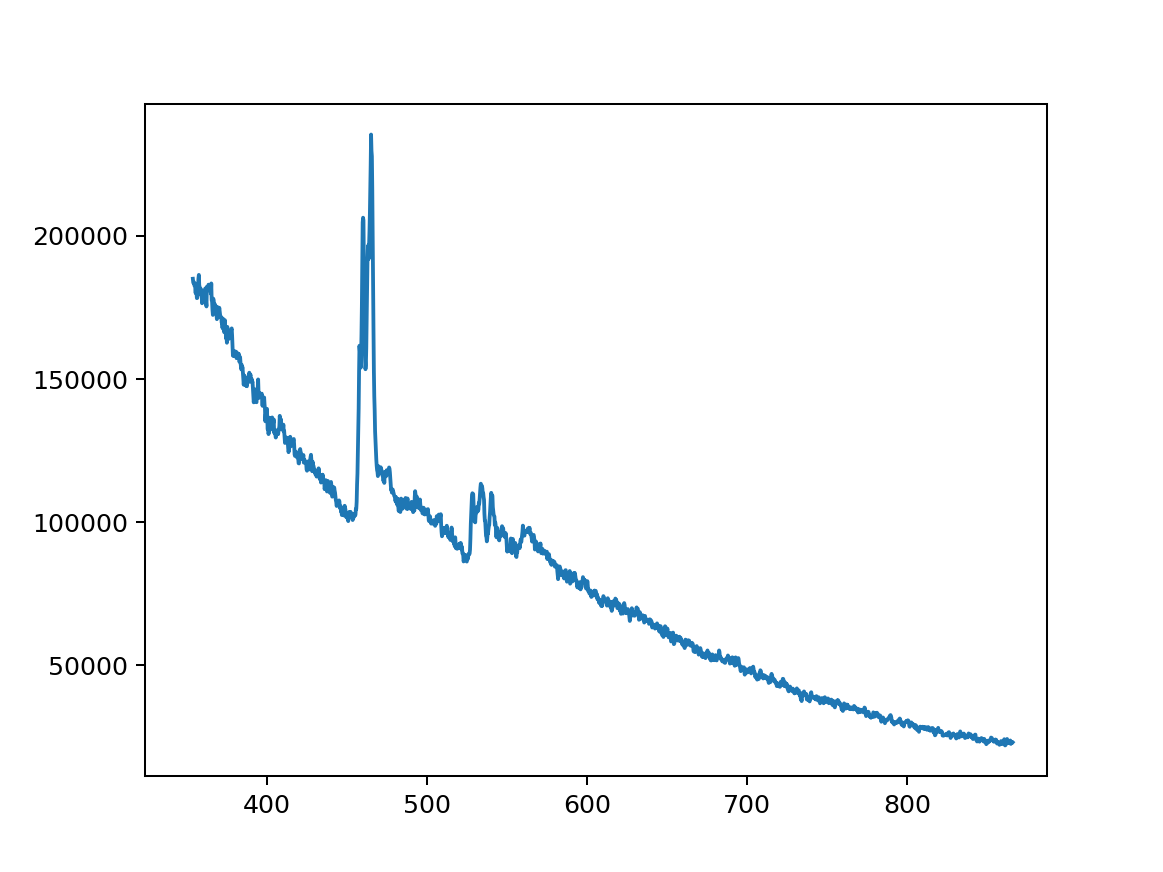

In [4]:
# current_dataset.metadata['edges'] = {'0': {}, 'model': {}}
composition = ieels.CompositionDialog(current_dataset)

### Output of Results

In [5]:
edges = current_dataset.metadata['edges']
element = []
areal_density = []
for key, edge in edges.items():
    if key.isdigit():
        element.append(edge['element'])
        areal_density.append(edge['areal_density'])

print('Relative chemical composition of ', current_dataset.title)
for i in range(len(element)):
    print(f'{element[i]}: {areal_density[i]/np.sum(areal_density)*100:.1f} %')
    
saved_edges_metadata = edges

Relative chemical composition of  01_EELS Acquire_STO
Ti: 21.2 %
O: 78.8 %


### Log Data
We write all the data to the hdf5 file associated with our dataset.

In our case that is only the ``metadata``, in which we stored the ``experimental parameters`` and the ``fitting parameters and result``.

In [6]:
current_group = current_dataset.h5_dataset.parent
if 'Log_000' not in current_group:
    log_group = current_group.create_group('Log_000')
    
log_group = current_group['Log_000']
if 'analysis' in log_group:
    del log_group['analysis'] 
log_group['analysis'] = 'EELS_quantification'
metadata = ft.flatten_dict(current_dataset.metadata)
for key, item in metadata.items():
    log_group.attrs[key]= item
current_group.file.flush()

In [7]:
ft.h5_tree(current_group.file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ 01_EELS Acquire_STO
    ├ Log_000
      -------
      ├ analysis
    ├ energy_loss
    ├ metadata
      --------
    ├ original_metadata
      -----------------


## ELNES
The electron energy-loss near edge structure is determined by fititng the spectrum after quantification model subtraction. 

First smooth the spectrum (2 iterations are ususally sufficient) and then 
find the number of peaks you want (Can be repeated as oftern as one wants).


<IPython.core.display.Javascript object>


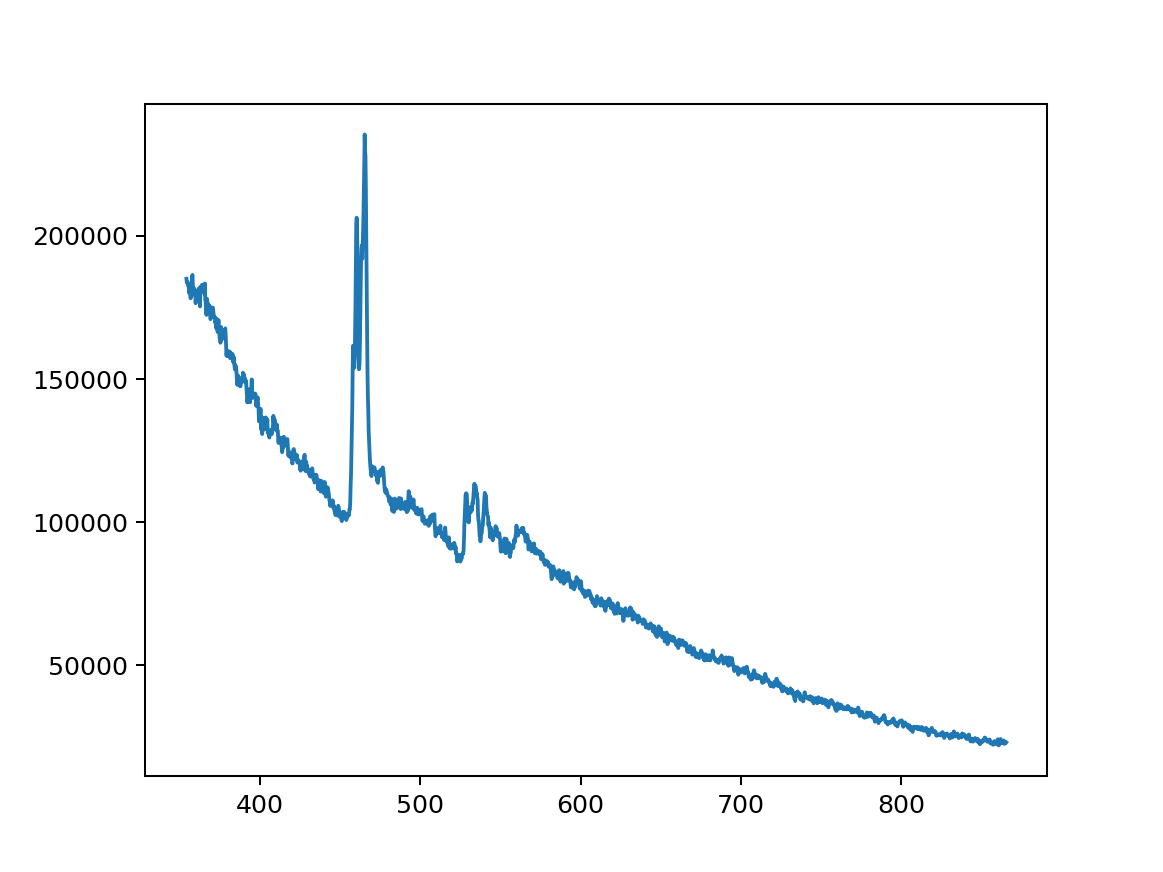

In [8]:
peak_dialog = ieels.PeakFitDialog(current_dataset)

In [62]:
print(peak_dialog.peak_da)

for key in peak_dialog.peaks['peaks']:
    if key.isdigit():
        print(key)
        
print(peak_dialog.peaks['peaks'])
current_dataset.metadata['peak_fit']['peaks'].keys()

True
0
{'0': {'position': 707.5, 'amplitude': 1000.0, 'width': 1.0, 'type': 'Gauss', 'asymmetry': 0}}


dict_keys(['0'])

### Output

In [50]:
areas = []
for p, peak in peak_dialog.peaks['peaks'].items():
    area = np.sqrt(2* np.pi)* peak['amplitude'] * np.abs(peak['width'] / np.sqrt(2 *np.log(2))) 
    areas.append(area)
    if 'associated_edge' not in peak:
        peak['associated_edge']= ''
    print(f"peak  {p}: position: {peak['position']:7.1f}, area: {area:12.3f} associated edge: {peak['associated_edge']}")
#print(f'\n M4/M5 peak 2 to peak 1 ratio: {(areas[1])/areas[0]:.2f}')

peak  0: position:   887.5, area:  1108828.834 associated edge: 
peak  1: position:   905.5, area:  1318287.152 associated edge: 
peak  2: position:   859.9, area:    79451.959 associated edge: 
peak  3: position:  1569.2, area:    58924.095 associated edge: 
peak  4: position:  1183.9, area:   104840.196 associated edge: 


### Log Data

In [14]:
current_group = current_dataset.h5_dataset.parent
if 'Log_001' not in current_group:
    log_group = current_group.create_group('Log_001')
    
log_group = current_group['Log_001']
if 'analysis' in log_group:
    del log_group['analysis'] 
log_group['analysis'] = 'ELNES_fit'
metadata = ft.flatten_dict(current_dataset.metadata)
for key, item in metadata.items():
    log_group.attrs[key]= item
current_group.file.flush()

print('Logged Data of ', current_dataset.title)
for key in current_group:
    if 'Log_' in key:
        if 'analysis' in current_group[key]:
            print(f" {key}: {current_group[key]['analysis'][()]}")

Logged Data of  01_EELS Acquire_STO
 Log_000: EELS_quantification
 Log_001: ELNES_fit


## Close File
File needs to be closed to be used with other notebooks

In [15]:
current_dataset.h5_dataset.file.close()

## Navigation
<font size = "5"> **Back: [Calculating Dielectric Function II: Silicon](DielectricDFT2.ipynb)** </font>

<font size = "5"> **Next: [ELNES](ELNES.ipynb)** </font>

<font size = "5"> **Chapter 4: [Spectroscopy](Spectroscopy.ipynb)** </font>

<font size = "5"> **Index: [Index](Analysis_of_Transmission_Electron_Microscope_Data.ipynb)** </font>